In [3]:
import drone
import sensor
import searchdomain
import filter
import policy
import cost
import util

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt4Agg')
from copy import deepcopy

In [27]:
choices = {
    (0.1, 0.1) : [(1.7, 0), (0, 1.7)],
    (0.9, 0.1) : [(-1.7, 0), (0, 1.7)],
    (0.1, 0.9) : [(1.7, 0), (0, -1.7)],
    (0.9, 0.9) : [(-1.7, 0), (0, -1.7)]
}

In [28]:
def setup():
    # search domain
    # domain length of 200
    # target moves at constant velocity across screen at 1.7 m/s
    # target starts at some position defined by choices dict
    # velocity randomly chosen
    init = random.choice(list(choices))
    dx, dy = random.choice(choices[init])
    m = searchdomain.SearchDomain(200, policy.ConstantVelocityPolicy(dx, dy, maxStep=1.7), init)

    # sensor
    # sensor returns estimated bearing measurement with sd=5.0 m
    s = sensor.BearingOnlySensor(5.0)

    # drone
    # drone starts out in the middle of search domain, (100, 100)
    # initial bearing of 60 degrees (arbitrarily chosen)
    # moves at 5.0 m/s
    d = drone.Drone(100, 100, 60, 5.0, s, m)

    # filter
    # binned into 64 buckets
    # particles propagate between -2.0 m/s and 2.0 m/s in a random direction
    # 2000 particles
    # f = filter.ParticleFilter(m, 64, s, 2.0, 2000)
    f = filter.DiscreteFilter(m, 64, s)
    
    # cost model
    # reward is +1 if largest bin is > 0.5
    # reward is -1 if P(near collision) > 0.5
    # reard is 0 otherwise
    # c = cost.DiscreteProbDistanceCostModel(15.0, 0.5, 0.5)

    # for greedy we are using pure distance to the mean belief
    c = cost.DistanceCostModel()

    # discrete actions
    # moving 2.0 m/s in a radial pattern about the drone
    # 37 different actions to choose from: null + 36 directions
    # cannot change heading, useful for dimensionality reduction in bearing only case
    p = policy.RLPolicy(d.maxStep, 36, headings=None)

    actions = p.actions
    
    return m, s, d, f, c, p, actions

In [29]:
m, s, d, f, c, p ,actions = setup()

In [30]:
# initial belief is equal distribution in the search domain
f.getBelief()

array([[[0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414],
        [0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414],
        [0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414],
        ...,
        [0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414],
        [0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414],
        [0.00024414, 0.00024414, 0.00024414, ..., 0.00024414,
         0.00024414, 0.00024414]]])

In [31]:
f.centroid()

(100.0, 100.0)

In [32]:
# this is about the highest entropy we can get in this setup
f.entropy()

8.317766166719341

In [33]:
# and here's the maximum eigenvalue of the covariance of the uncertainty matrix
f.maxEigenvalue()

3332.51953125

In [34]:
# and finally the highest probability of all the buckets
f.maxProbBucket()

0.000244140625

In [35]:
def plotParticle(f, d=None, m=None):
    belief = f.getBelief()
    belief = belief.squeeze(0)
    x_particles = f.x_particles
    y_particles = f.y_particles
    plt.xlim(0, 200.0)
    plt.ylim(0, 200.0)
    plt.title('Belief Distribution')
    plt.scatter(x_particles, y_particles, marker='o', c='k', s = (72. / plt.gcf().dpi) ** 2)
    
    if d is not None and m is not None:
        x, y, heading = d.getPose()
        theta_x, theta_y = m.getTheta()
        theta_dx, theta_dy = m.policy.dx, m.policy.dy
        # ensuring that we get correct rotation of seeker
        marker = matplotlib.markers.MarkerStyle(marker=r'$\wedge$')
        marker._transform = marker.get_transform().rotate_deg(-heading)
        plt.scatter(x, y, marker=marker)
        plt.plot(theta_x, theta_y, 'rx')
    
        ent = f.entropy()
        max_eig = f.maxEigenvalue()
        max_prob = f.maxProbBucket()
        dist = np.linalg.norm(np.array([x, y]) - np.array([theta_x, theta_y]))
        tracking = np.linalg.norm(np.array(f.centroid()) - np.array([theta_x, theta_y]))
        mean_dx, mean_dy = f.mean_velocity()
        toptxt = 'Entropy: {:.4f}, Max Eig: {:.1f}, Max Prob: {:.3f}, Mean Particle Velocity: ({:.1f}, {:.1f})'.format(ent, max_eig, max_prob, mean_dx, mean_dy)
        bottxt = 'Distance: {:.1f}, Tracking Error: {:.2f}, Target Velocity: ({:.1f}, {:.1f})'.format(dist, tracking, theta_dx, theta_dy)
        plt.figtext(0.01, 0.01, bottxt, wrap=True, horizontalAlignment='left', fontsize=8)
        plt.figtext(0.01, 0.04, toptxt, wrap=True, horizontalAlignment='left', fontsize=8)
        plt.show()
        plt.close()
        
def plotDiscrete(f, d=None, m=None):
    belief = f.getBelief()
    belief = belief.squeeze(0)
    scale_factor = m.length / f.buckets
    plt.title('Belief Distribution')
    plt.imshow(belief.reshape(f.buckets, f.buckets).repeat(scale_factor, axis=0).repeat(scale_factor, axis=1), cmap='plasma')
    plt.colorbar()
    
    if d is not None and m is not None:
        x, y, heading = d.getPose()
        theta_x, theta_y = m.getTheta()
        theta_dx, theta_dy = m.policy.dx, m.policy.dy
        # ensuring that we get correct rotation of seeker
        marker = matplotlib.markers.MarkerStyle(marker=r'$\wedge$')
        marker._transform = marker.get_transform().rotate_deg(-heading)
        plt.scatter(x, y, marker=marker)
        plt.plot(theta_x, theta_y, 'rx')
    
        ent = f.entropy()
        max_eig = f.maxEigenvalue()
        max_prob = f.maxProbBucket()
        dist = np.linalg.norm(np.array([x, y]) - np.array([theta_x, theta_y]))
        tracking = np.linalg.norm(np.array(f.centroid()) - np.array([theta_x, theta_y]))
        toptxt = 'Entropy: {:.4f}, Max Eig: {:.1f}, Max Prob: {:.3f}'.format(ent, max_eig, max_prob)
        bottxt = 'Distance: {:.1f}, Tracking Error: {:.2f}, Target Velocity: ({:.1f}, {:.1f})'.format(dist, tracking, theta_dx, theta_dy)
        plt.figtext(0.01, 0.01, bottxt, wrap=True, horizontalAlignment='left', fontsize=8)
        plt.figtext(0.01, 0.04, toptxt, wrap=True, horizontalAlignment='left', fontsize=8)
        plt.show()
        plt.close()

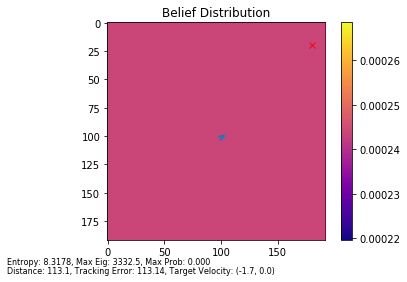

In [36]:
plotDiscrete(f, d, m)

In [37]:
def step(m, d, f, a, c, plot=True):
    obs = s.observe(m.getTheta(), d.getPose())
    f.update(d.getPose(), obs)
    if plot:
        plotDiscrete(f, d, m)
    d.act(a)
    m.moveTarget()
    reward = c.getCost(m, d, f, a)
    return obs, reward, False, {}

In [38]:
def greedy(actions, m, d, f, c):
    best_action = (0, 0, 0)
    best_reward = float('-inf')
    for i in range(len(actions)):   
        m_copy, d_copy, f_copy = deepcopy(m), deepcopy(d), deepcopy(f)
        a = actions[i]
        _, reward, _, _ = step(m_copy, d_copy, f_copy, a, c, plot=False)
        if reward > best_reward:
            best_action = a
            best_reward = reward
    return best_action

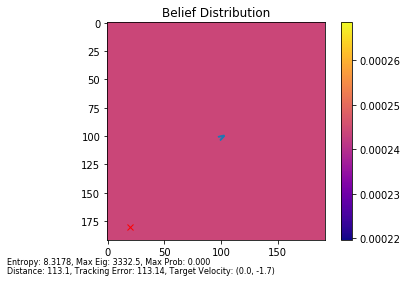

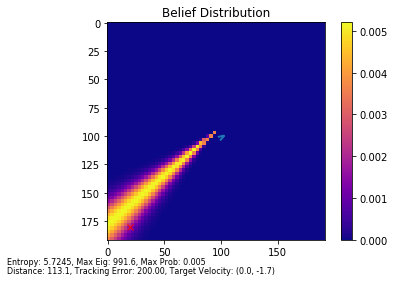

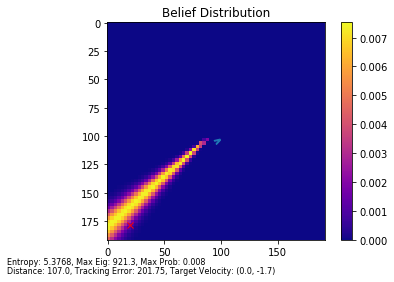

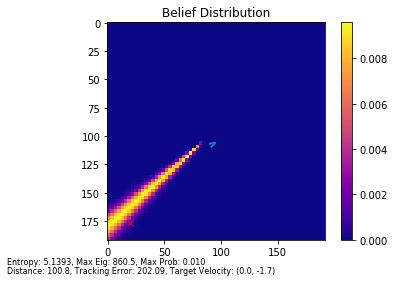

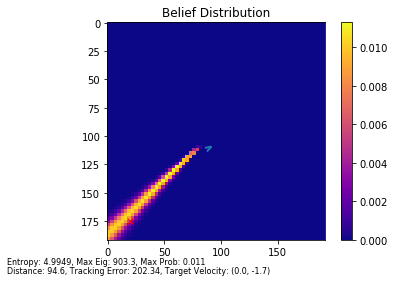

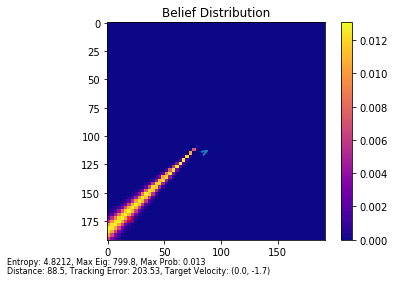

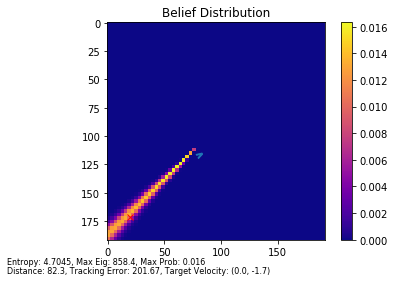

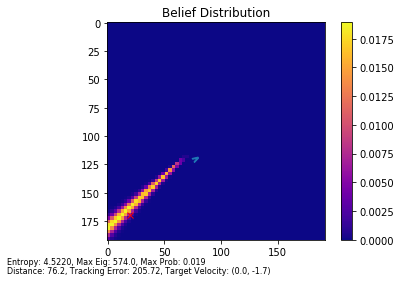

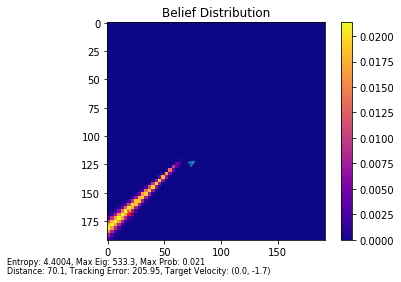

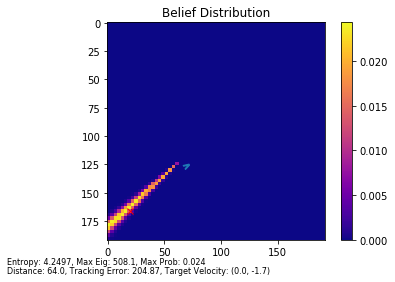

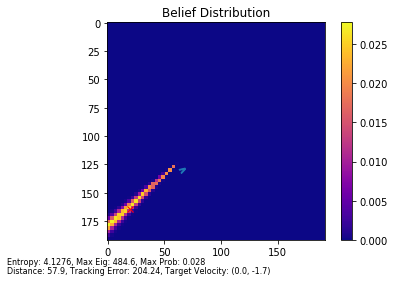

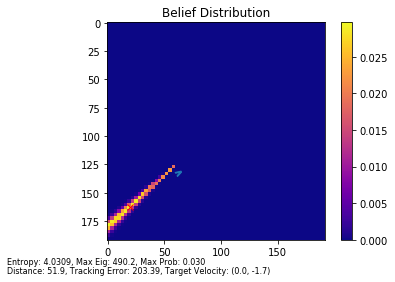

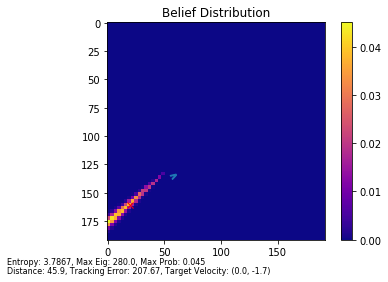

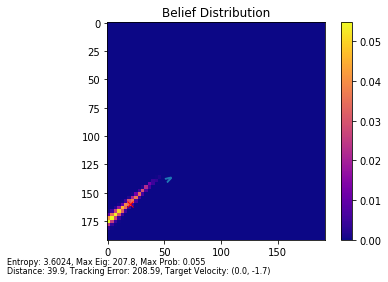

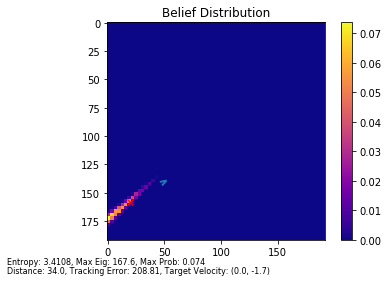

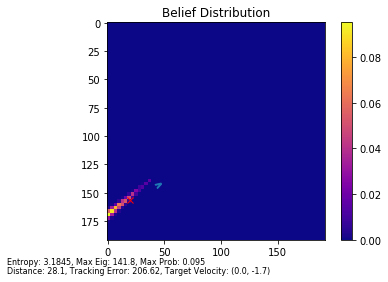

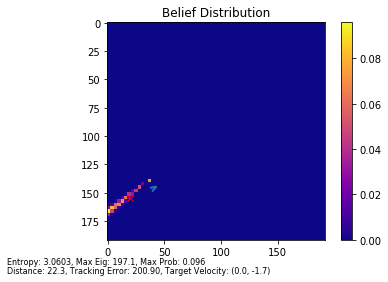

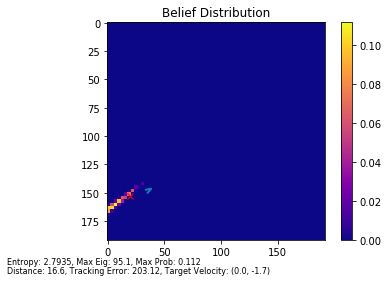

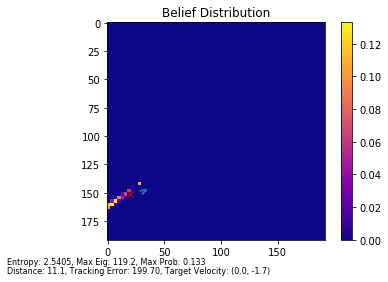

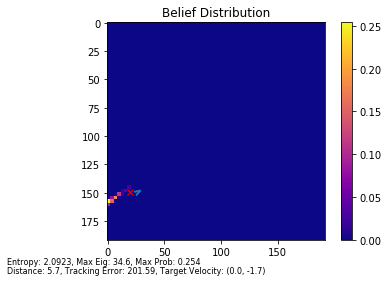

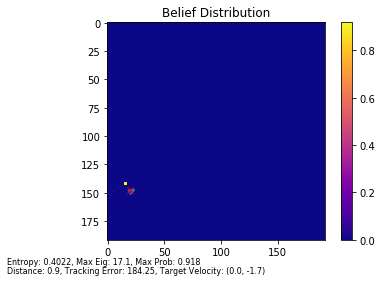

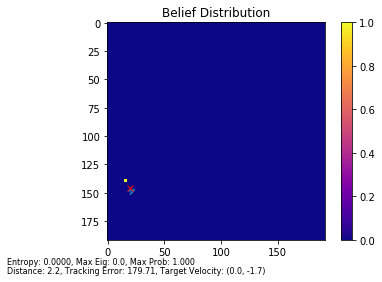

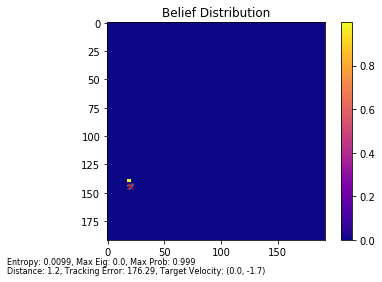

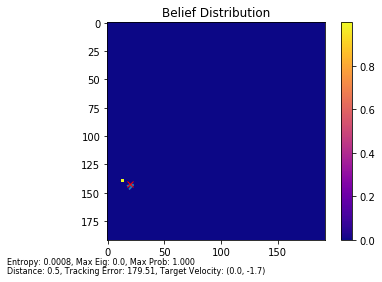

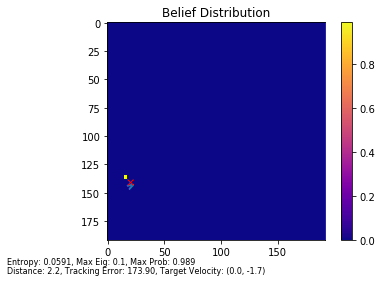

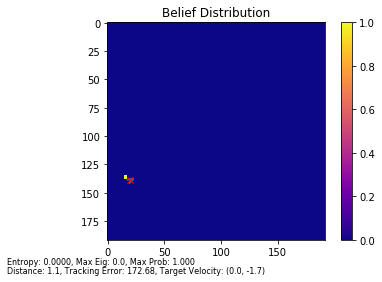

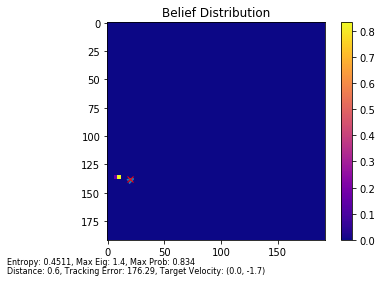

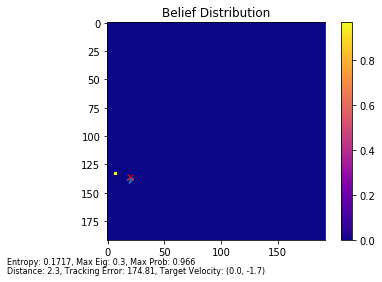

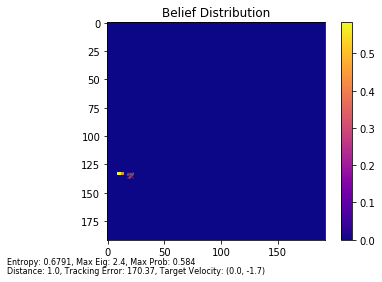

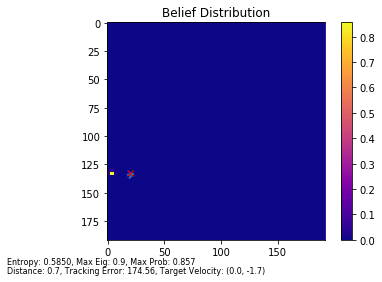

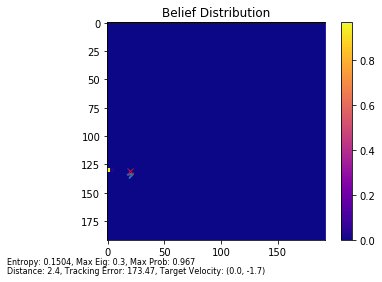

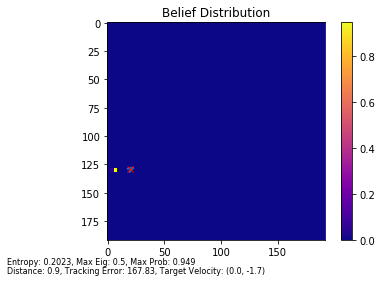

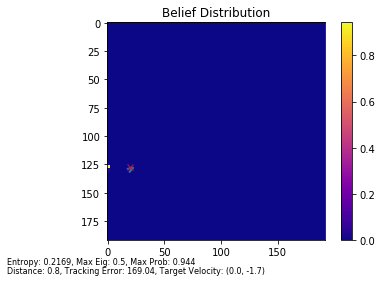

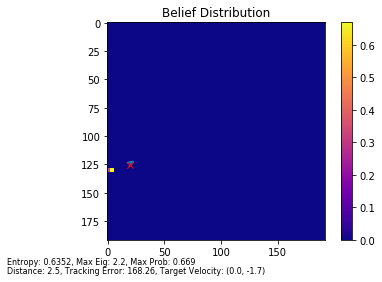

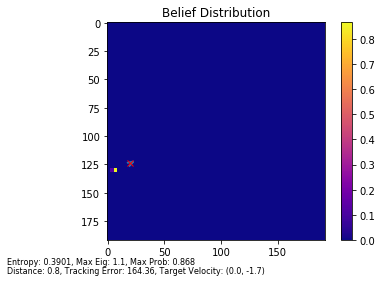

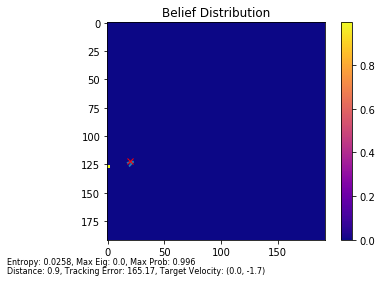

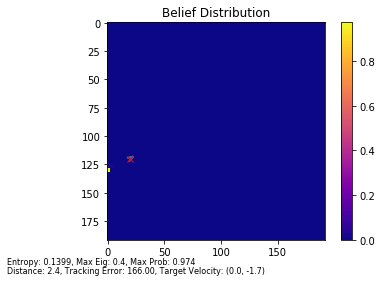

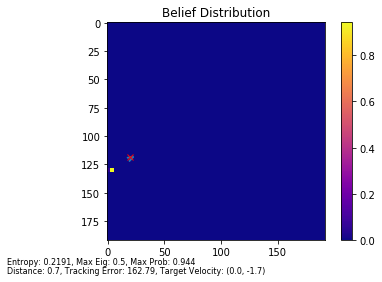

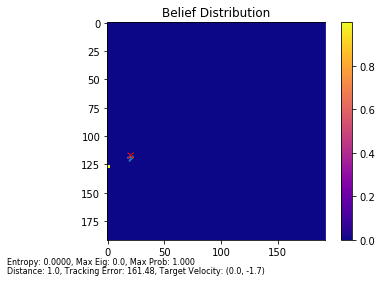

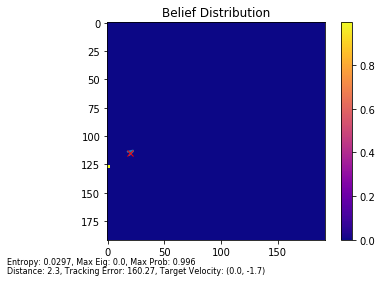

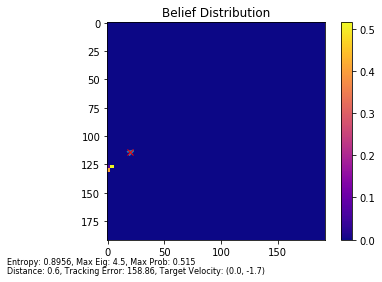

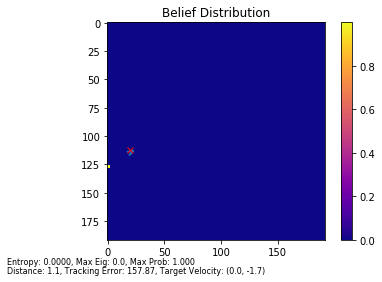

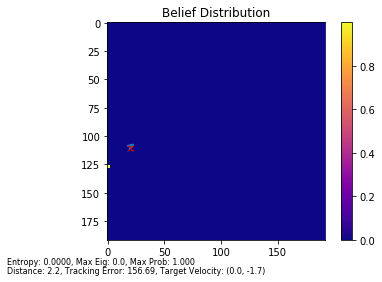

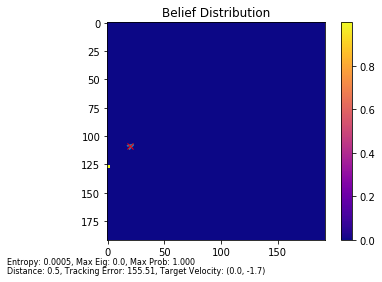

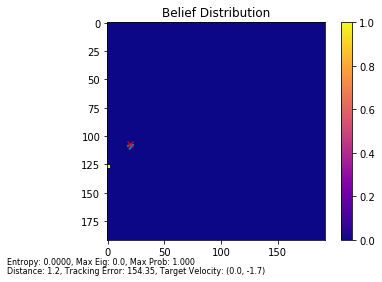

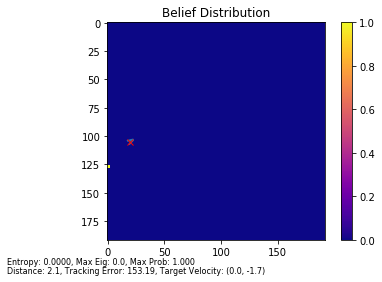

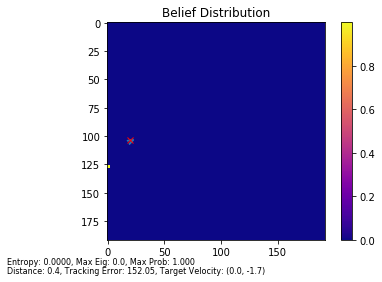

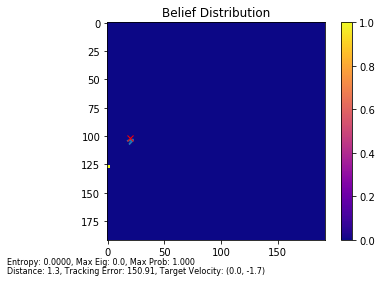

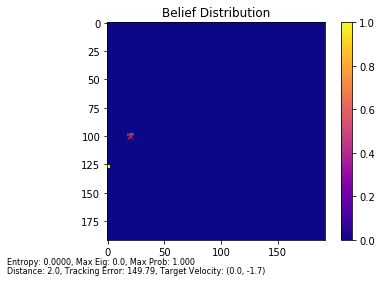

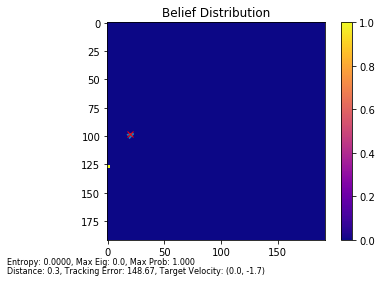

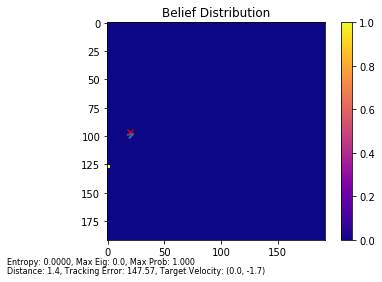

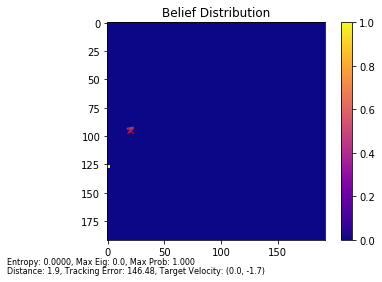

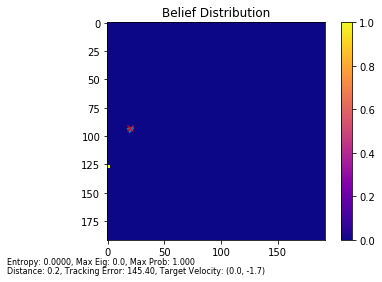

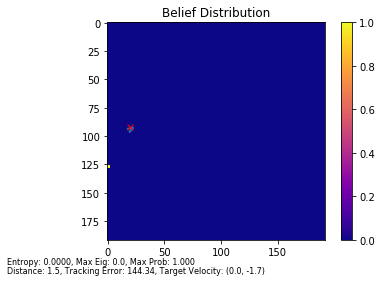

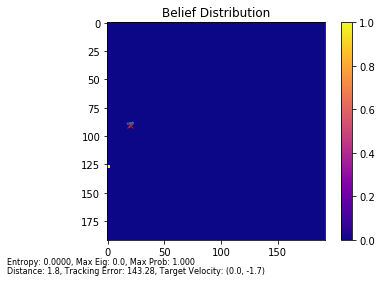

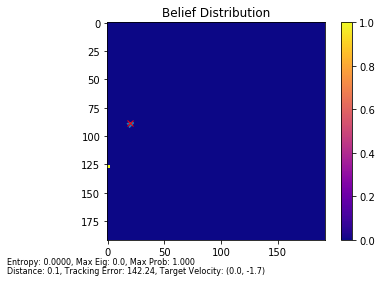

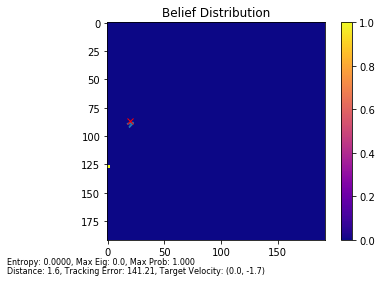

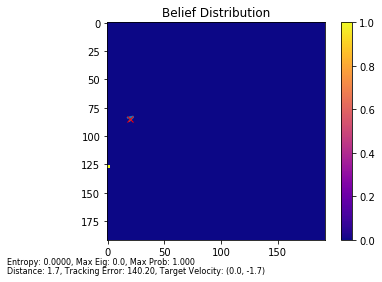

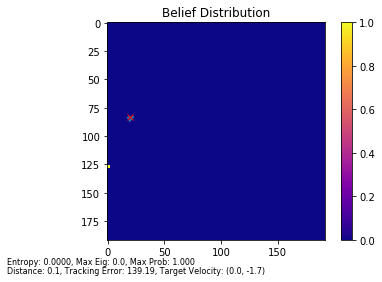

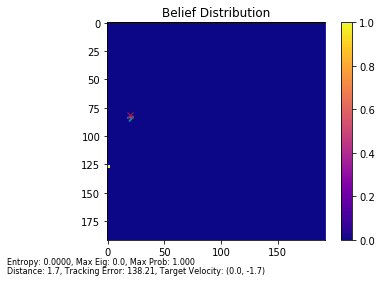

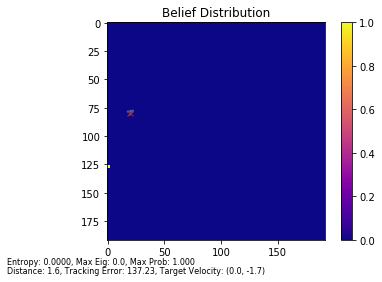

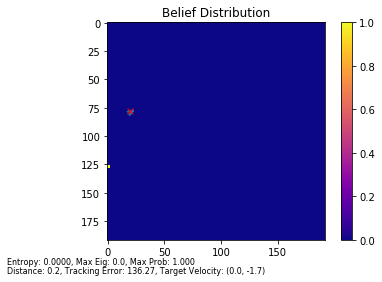

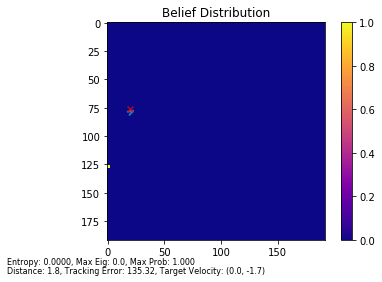

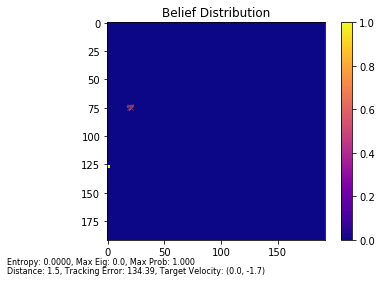

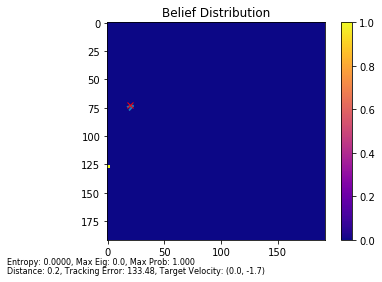

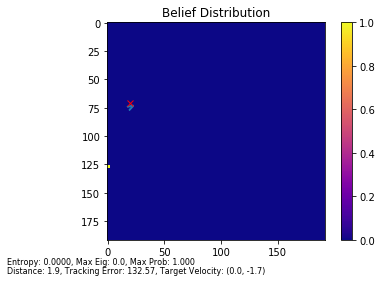

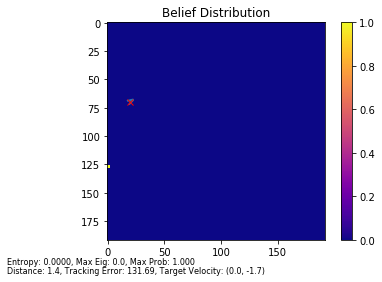

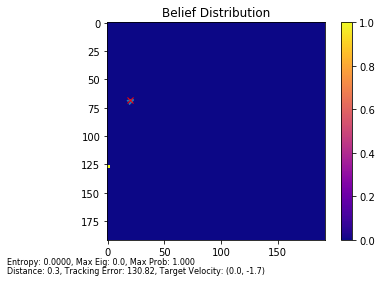

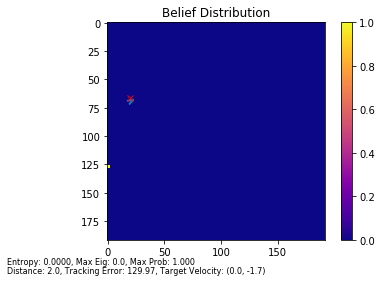

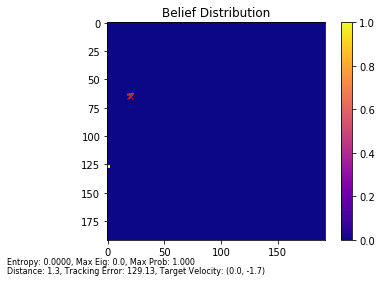

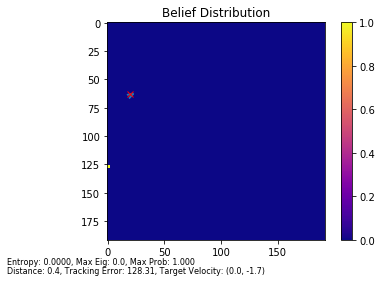

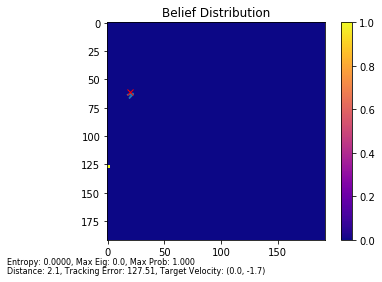

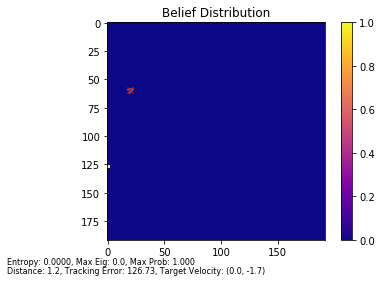

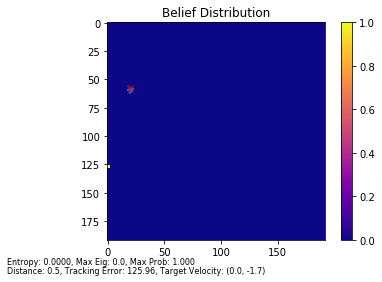

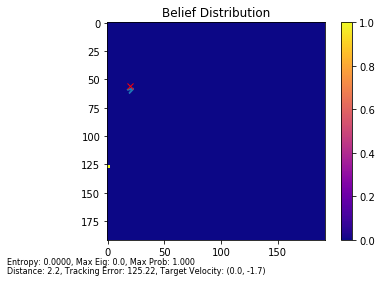

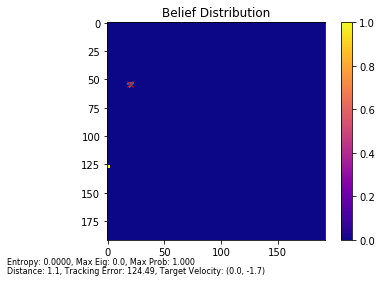

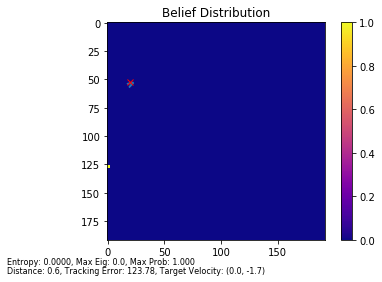

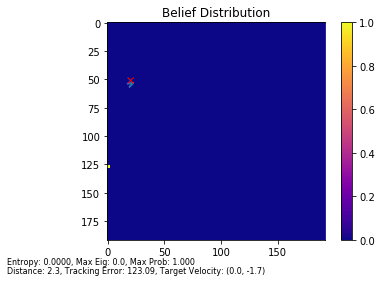

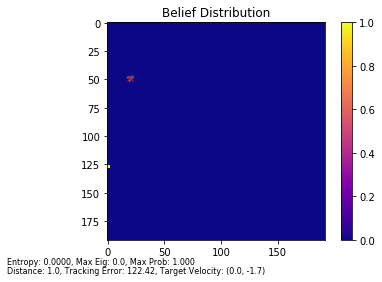

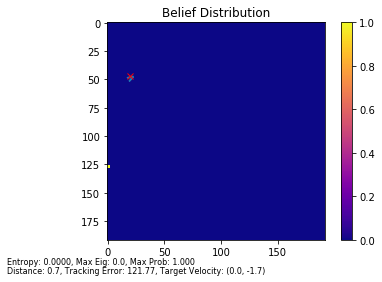

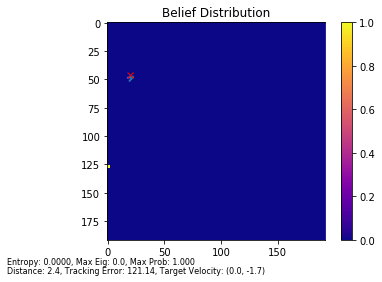

episode reward:  -1075.7240132758498


In [39]:
m, s, d, f, c, p ,actions = setup()

# 80 timesteps per episode
plotDiscrete(f, d, m)
episode_reward = 0.0
for t in range(80):
    a = greedy(actions, m, d, f, c)
    obs, reward, _, _ = step(m, d, f, a, c)
    episode_reward += reward
print('episode reward: ', episode_reward)